Device in use: cuda
Original image shape: (1024, 1024, 3) Type: uint8


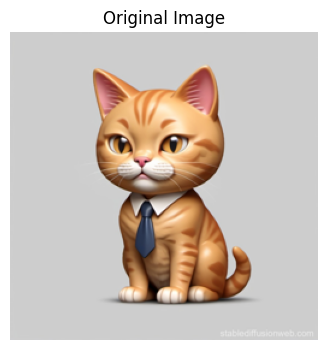

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image
import pandas as pd
import os
import pickle

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(
        original, reconstructed, data_range=original.max() - original.min()
    )
    return mse_value, psnr_value

# Load image
image_url = "1.jpg"  # Ensure '1.jpg' is in the current working directory
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

# Resize image to 256x256
image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((256,256)))

# Display the original image
plt.figure(figsize=(6, 4))
if image_original.dtype in [np.float32, np.float64]:
    plt.imshow(image_original / 255.0)
else:
    plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Normalize image to [0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

Sampling Iterations: 100%|██████████| 2000/2000 [00:20<00:00, 97.79it/s] 


Sampling phase completed in 20.45 seconds
Total sample points collected: 20001
Reconstruction phase completed in 0.01 seconds
Average Predicted Image - MSE: 0.008333, PSNR: 20.79dB
Optimized Predicted Image - MSE: 0.005993, PSNR: 22.22dB


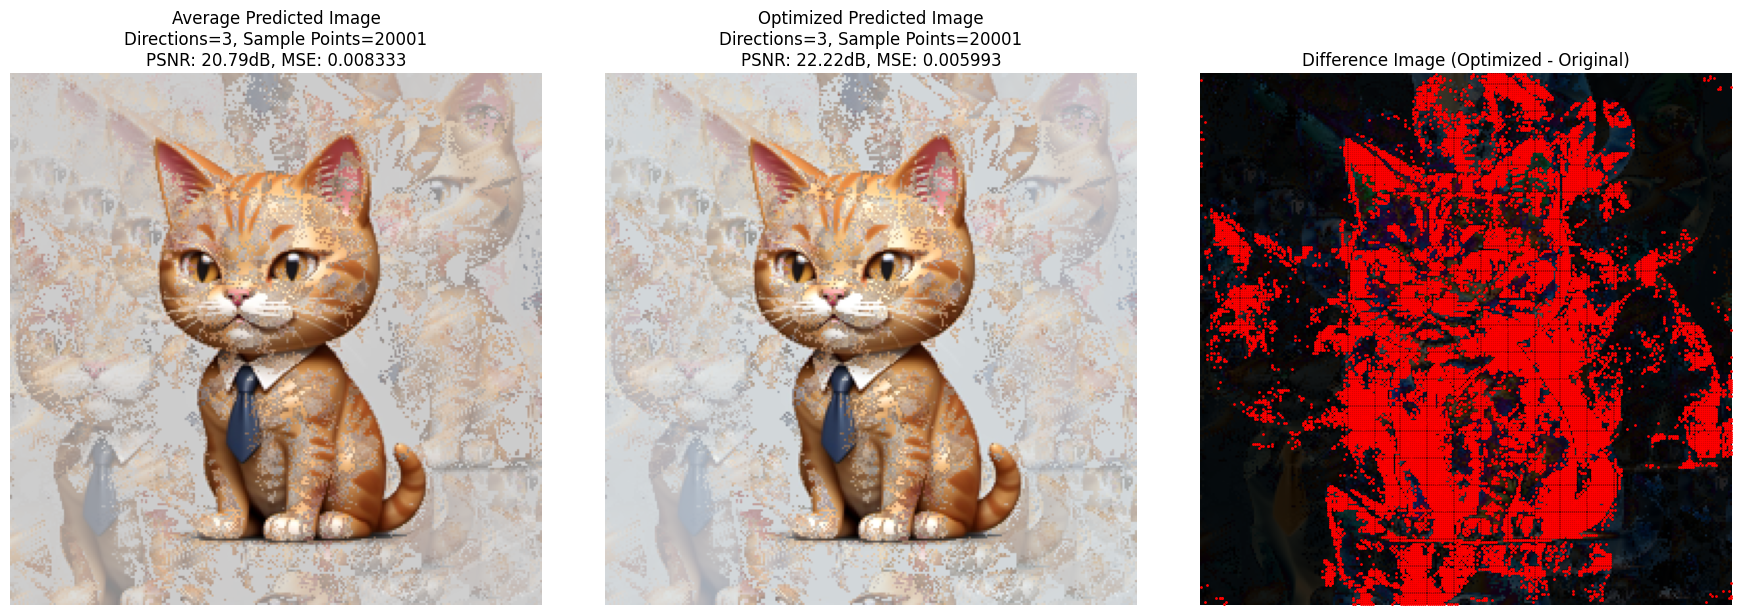

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

torch.manual_seed(9)

# Define functions
def generate_random_directions(num_directions):
    # Generate the first random angle
    print()
    theta0 = torch.rand(1, device=device) * 2 * np.pi  # Random angle in [0, 2π)

    # Compute angle increment
    delta_theta = 2 * np.pi / num_directions

    # Generate the angles starting from theta0
    if num_directions > 1:
        angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
    else:
        angles = theta0

    # Wrap angles back into [0, 2π)
    angles = angles % (2 * np.pi)

    # Compute directions
    directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    directions = [(dx.item(), dy.item()) for dx, dy in directions]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Parameters for Analysis
num_directions_sampling = 3  # More directions during sampling
num_iterations_sampling = 2000  # Number of iterations for sampling

# num_directions_reconstruction = 4  # Fewer directions during reconstruction

# Sampling Phase
# Generate random directions for sampling
directions_sampling = generate_random_directions(num_directions_sampling)

# Initialize sample points
initial_sample_size = 1
sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

Py, Px = torch.meshgrid(
    torch.arange(height, device=device),
    torch.arange(width, device=device),
    indexing='ij'
)
Px = Px.flatten()
Py = Py.flatten()

# Sampling process
start_time_sampling = time.time()
for t in tqdm(range(num_iterations_sampling), desc="Sampling Iterations"):
    downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
    av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
    combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

    for idx in range(num_directions_sampling):
        dx, dy = directions_sampling[idx]
        curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
        pv_channels = []
        for c in range(channels):
            curve = curves[c]
            pv = torch_interp_lerp(
                calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                curve[:, 0], curve[:, 1]
            )
            pv_channels.append(pv)
        pv = torch.stack(pv_channels, dim=1)
        combined_predicted_values += pv

    combined_predicted_values /= num_directions_sampling
    downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

    top_k_indices = torch.argsort(downsampled_error)[-10:]
    error_y = downsampled_Py[top_k_indices]
    error_x = downsampled_Px[top_k_indices]

    sampled_Px = torch.cat([sampled_Px, error_x])
    sampled_Py = torch.cat([sampled_Py, error_y])
    sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

sampling_time = time.time() - start_time_sampling
print(f"Sampling phase completed in {sampling_time:.2f} seconds")
print(f"Total sample points collected: {len(sampled_Px)}")

# Reconstruction Phase
# Generate random directions for reconstruction
# directions_reconstruction = generate_random_directions(num_directions_reconstruction)

# Reconstruct images using the selected sample points and fewer directions
start_time_reconstruction = time.time()
final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_sampling):
    dx, dy = directions_sampling[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    final_predicted_image_sum += predicted_image

final_predicted_image_avg = final_predicted_image_sum / num_directions_sampling
final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
reconstructed_avg = final_predicted_image_avg.cpu().numpy() / 255.0

# Evaluation metrics
mse_avg, psnr_avg = calculate_metrics(image, reconstructed_avg)

reconstruction_time = time.time() - start_time_reconstruction
print(f"Reconstruction phase completed in {reconstruction_time:.2f} seconds")
print(f"Average Predicted Image - MSE: {mse_avg:.6f}, PSNR: {psnr_avg:.2f}dB")

# Optimized Reconstruction using Least Squares
# Sample a subset of pixels for the least squares problem
num_samples_ls = 10000
sample_indices_ls = torch.randint(0, height * width, (num_samples_ls,), device=device)
sampled_Px_ls = (sample_indices_ls % width).long()
sampled_Py_ls = (sample_indices_ls // width).long()
original_values_ls = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

# Initialize X matrix for least squares
X_ls = torch.zeros((num_samples_ls, num_directions_sampling, channels), device=device)
for idx in range(num_directions_sampling):
    dx, dy = directions_sampling[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    for c in range(channels):
        curve = curves[c]
        predicted_values = torch_interp_lerp(
            calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
            curve[:, 0], curve[:, 1]
        )
        X_ls[:, idx, c] = predicted_values

# Solve least squares problem for each channel
w_opt = torch.zeros((num_directions_sampling, channels), device=device)
for c in range(channels):
    X_channel = X_ls[:, :, c]
    y_channel = original_values_ls[:, c]
    solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
    w_opt_channel = solution.solution.squeeze()
    w_opt[:, c] = w_opt_channel

# Reconstruct the final predicted image using optimized weights
final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_sampling):
    dx, dy = directions_sampling[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    for c in range(channels):
        final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
reconstructed_opt = final_predicted_image_opt.cpu().numpy() / 255.0

# Optimized evaluation metrics
mse_opt, psnr_opt = calculate_metrics(image, reconstructed_opt)
print(f"Optimized Predicted Image - MSE: {mse_opt:.6f}, PSNR: {psnr_opt:.2f}dB")

# Difference Image (Optimized - Original)
difference_image = np.abs(reconstructed_opt - image)

# Plotting Results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(reconstructed_avg)
axes[0].set_title(
    f'Average Predicted Image\nDirections={num_directions_sampling}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_avg:.2f}dB, MSE: {mse_avg:.6f}'
)
axes[0].axis('off')

axes[1].imshow(reconstructed_opt)
axes[1].set_title(
    f'Optimized Predicted Image\nDirections={num_directions_sampling}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_opt:.2f}dB, MSE: {mse_opt:.6f}'
)
axes[1].axis('off')

axes[2].imshow(difference_image)
axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label='Sample Points')
axes[2].set_title('Difference Image (Optimized - Original)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Selected directions_reconstruction indices: [0, 4, 8, 13, 17, 21, 25, 29, 34, 38, 42, 46, 50, 55, 59, 63]
Selected directions_reconstruction: [(0.7152150869369507, -0.6989044547080994), (0.9282317757606506, -0.37200242280960083), (0.9999334812164307, 0.011533004231750965), (0.8764258027076721, 0.48153698444366455), (0.6254358887672424, 0.7802755832672119), (0.27922871708869934, 0.9602246284484863), (-0.10948805510997772, 0.9939880967140198), (-0.48153671622276306, 0.8764259219169617), (-0.8378220200538635, 0.5459434986114502), (-0.9829699993133545, 0.183766171336174), (-0.9784699082374573, -0.2063896209001541), (-0.825006902217865, -0.565122663974762), (-0.5459437370300293, -0.8378218412399292), (-0.08653246611356735, -0.9962490200996399), (0.30130165815353394, -0.953528881072998), (0.6432669758796692, -0.765641987323761)]


Sampling Iterations: 100%|██████████| 2000/2000 [06:28<00:00,  5.15it/s]


Sampling phase completed in 388.29 seconds
Total sample points collected: 20001
Reconstruction phase completed in 0.05 seconds
Average Predicted Image - MSE: 0.007917, PSNR: 21.01dB
Optimized Predicted Image - MSE: 0.002100, PSNR: 26.78dB


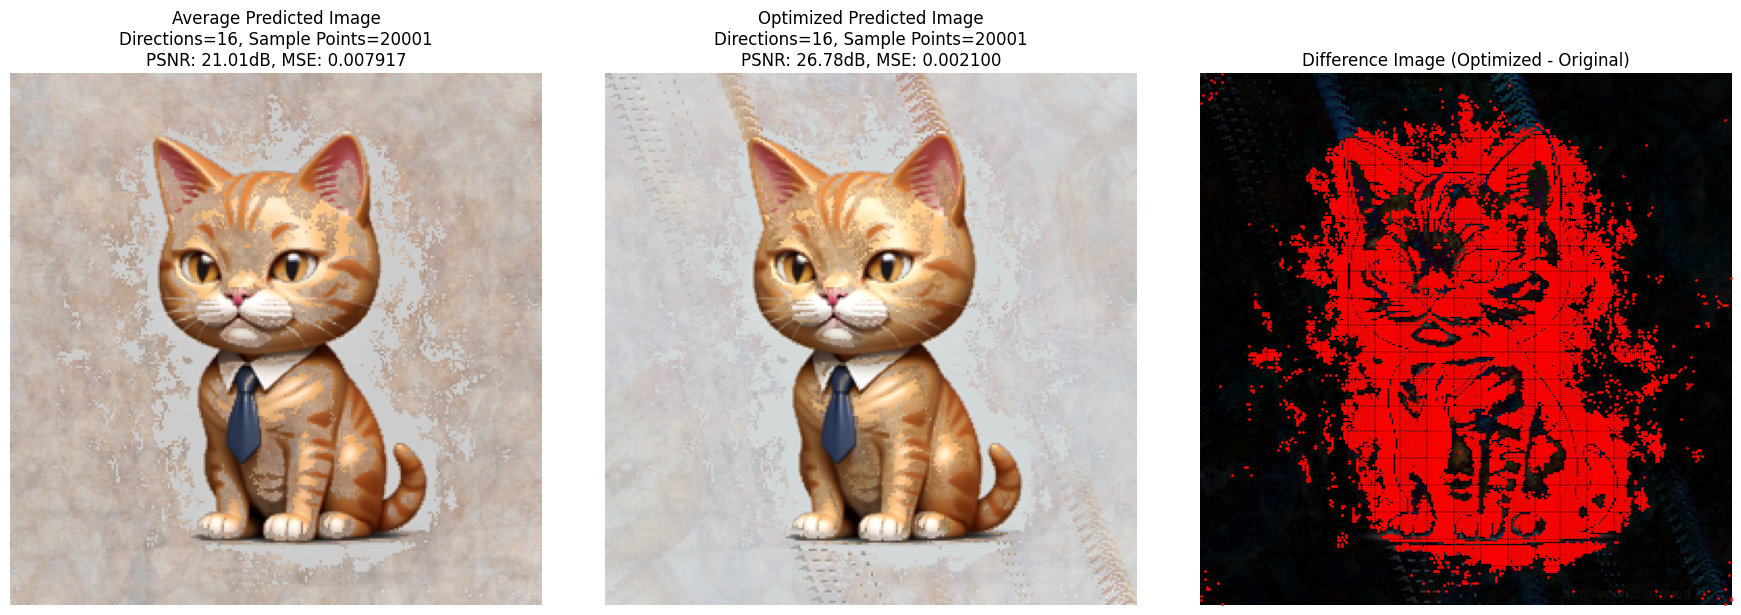

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# 假设 device, width, height, channels, image_tensor, image 已经在之前定义

# Define functions (保持不变)
def generate_random_directions(num_directions):
    theta0 = torch.rand(1, device=device) * 2 * np.pi  # Random angle in [0, 2π)
    delta_theta = 2 * np.pi / num_directions
    if num_directions > 1:
        angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
    else:
        angles = theta0
    angles = angles % (2 * np.pi)
    directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    directions = [(dx.item(), dy.item()) for dx, dy in directions]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)
    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]
    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

def calculate_metrics(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    psnr = peak_signal_noise_ratio(original, reconstructed, data_range=1.0)
    return mse, psnr

# Parameters for Analysis
num_directions_sampling = 64  # More directions during sampling
num_iterations_sampling = 2000  # Number of iterations for sampling

num_directions_reconstruction = 16  # Fewer directions during reconstruction

# Sampling Phase
# Generate random directions for sampling
directions_sampling = generate_random_directions(num_directions_sampling)

# 选择 directions_reconstruction 从 directions_sampling 中以相同间隔选取
if num_directions_reconstruction > num_directions_sampling:
    raise ValueError("num_directions_reconstruction 不能大于 num_directions_sampling")
stride = num_directions_sampling / num_directions_reconstruction
# 使用 torch.linspace 生成均匀分布的索引，并转换为整数
indices = torch.linspace(0, num_directions_sampling - 1, steps=num_directions_reconstruction).round().long()
directions_reconstruction = [directions_sampling[i] for i in indices]

# 打印以验证选择的方向
print(f"Selected directions_reconstruction indices: {indices.tolist()}")
print(f"Selected directions_reconstruction: {directions_reconstruction}")

# Initialize sample points
initial_sample_size = 1
sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

Py, Px = torch.meshgrid(
    torch.arange(height, device=device),
    torch.arange(width, device=device),
    indexing='ij'
)
Px = Px.flatten()
Py = Py.flatten()

# Sampling process
start_time_sampling = time.time()
for t in tqdm(range(num_iterations_sampling), desc="Sampling Iterations"):
    downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
    av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
    combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

    for idx in range(num_directions_sampling):
        dx, dy = directions_sampling[idx]
        curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
        pv_channels = []
        for c in range(channels):
            curve = curves[c]
            pv = torch_interp_lerp(
                calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                curve[:, 0], curve[:, 1]
            )
            pv_channels.append(pv)
        pv = torch.stack(pv_channels, dim=1)
        combined_predicted_values += pv

    combined_predicted_values /= num_directions_sampling
    downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

    top_k_indices = torch.argsort(downsampled_error)[-10:]
    error_y = downsampled_Py[top_k_indices]
    error_x = downsampled_Px[top_k_indices]

    sampled_Px = torch.cat([sampled_Px, error_x])
    sampled_Py = torch.cat([sampled_Py, error_y])
    sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

sampling_time = time.time() - start_time_sampling
print(f"Sampling phase completed in {sampling_time:.2f} seconds")
print(f"Total sample points collected: {len(sampled_Px)}")

# Reconstruction Phase
# 使用从 directions_sampling 中选取的 directions_reconstruction

start_time_reconstruction = time.time()
final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_reconstruction):
    dx, dy = directions_reconstruction[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    final_predicted_image_sum += predicted_image

final_predicted_image_avg = final_predicted_image_sum / num_directions_reconstruction
final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
reconstructed_avg = final_predicted_image_avg.cpu().numpy() / 255.0

# Evaluation metrics
mse_avg, psnr_avg = calculate_metrics(image, reconstructed_avg)

reconstruction_time = time.time() - start_time_reconstruction
print(f"Reconstruction phase completed in {reconstruction_time:.2f} seconds")
print(f"Average Predicted Image - MSE: {mse_avg:.6f}, PSNR: {psnr_avg:.2f}dB")

# Optimized Reconstruction using Least Squares
# Sample a subset of pixels for the least squares problem
num_samples_ls = 10000
sample_indices_ls = torch.randint(0, height * width, (num_samples_ls,), device=device)
sampled_Px_ls = (sample_indices_ls % width).long()
sampled_Py_ls = (sample_indices_ls // width).long()
original_values_ls = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

# Initialize X matrix for least squares
X_ls = torch.zeros((num_samples_ls, num_directions_reconstruction, channels), device=device)
for idx in range(num_directions_reconstruction):
    dx, dy = directions_reconstruction[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    for c in range(channels):
        curve = curves[c]
        predicted_values = torch_interp_lerp(
            calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
            curve[:, 0], curve[:, 1]
        )
        X_ls[:, idx, c] = predicted_values

# Solve least squares problem for each channel
w_opt = torch.zeros((num_directions_reconstruction, channels), device=device)
for c in range(channels):
    X_channel = X_ls[:, :, c]
    y_channel = original_values_ls[:, c]
    solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
    w_opt_channel = solution.solution.squeeze()
    w_opt[:, c] = w_opt_channel

# Reconstruct the final predicted image using optimized weights
final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_reconstruction):
    dx, dy = directions_reconstruction[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    for c in range(channels):
        final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
reconstructed_opt = final_predicted_image_opt.cpu().numpy() / 255.0

# Optimized evaluation metrics
mse_opt, psnr_opt = calculate_metrics(image, reconstructed_opt)
print(f"Optimized Predicted Image - MSE: {mse_opt:.6f}, PSNR: {psnr_opt:.2f}dB")

# Difference Image (Optimized - Original)
difference_image = np.abs(reconstructed_opt - image)

# Plotting Results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(reconstructed_avg)
axes[0].set_title(
    f'Average Predicted Image\nDirections={num_directions_reconstruction}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_avg:.2f}dB, MSE: {mse_avg:.6f}'
)
axes[0].axis('off')

axes[1].imshow(reconstructed_opt)
axes[1].set_title(
    f'Optimized Predicted Image\nDirections={num_directions_reconstruction}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_opt:.2f}dB, MSE: {mse_opt:.6f}'
)
axes[1].axis('off')

axes[2].imshow(difference_image)
axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label='Sample Points')
axes[2].set_title('Difference Image (Optimized - Original)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Sampling Iterations: 100%|██████████| 2000/2000 [06:36<00:00,  5.04it/s]


Sampling phase completed in 396.55 seconds
Total sample points collected: 20001
Reconstruction phase completed in 0.02 seconds
Average Predicted Image - MSE: 0.013857, PSNR: 18.58dB
Optimized Predicted Image - MSE: 0.010886, PSNR: 19.63dB


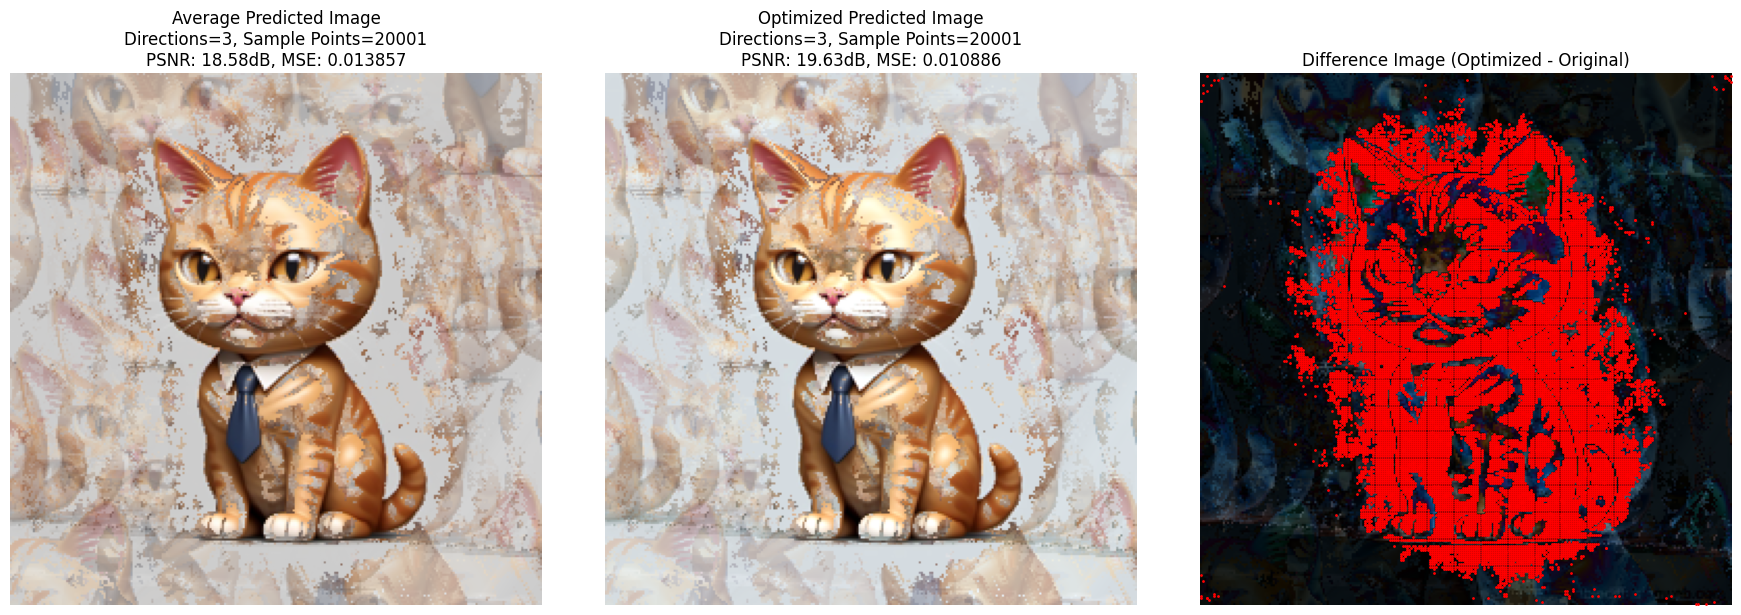

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image


# Define functions
def generate_random_directions(num_directions):
    # Generate the first random angle
    theta0 = torch.rand(1, device=device) * 2 * np.pi  # Random angle in [0, 2π)

    # Compute angle increment
    delta_theta = 2 * np.pi / num_directions

    # Generate the angles starting from theta0
    if num_directions > 1:
        angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
    else:
        angles = theta0

    # Wrap angles back into [0, 2π)
    angles = angles % (2 * np.pi)

    # Compute directions
    directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    directions = [(dx.item(), dy.item()) for dx, dy in directions]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Parameters for Analysis
num_directions_sampling = 64  # More directions during sampling
num_iterations_sampling = 2000  # Number of iterations for sampling

num_directions_reconstruction =3  # Fewer directions during reconstruction

# Sampling Phase
# Generate random directions for sampling
directions_sampling = generate_random_directions(num_directions_sampling)

# Initialize sample points
initial_sample_size = 1
sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

Py, Px = torch.meshgrid(
    torch.arange(height, device=device),
    torch.arange(width, device=device),
    indexing='ij'
)
Px = Px.flatten()
Py = Py.flatten()

# Sampling process
start_time_sampling = time.time()
for t in tqdm(range(num_iterations_sampling), desc="Sampling Iterations"):
    downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
    av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
    combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

    for idx in range(num_directions_sampling):
        dx, dy = directions_sampling[idx]
        curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
        pv_channels = []
        for c in range(channels):
            curve = curves[c]
            pv = torch_interp_lerp(
                calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                curve[:, 0], curve[:, 1]
            )
            pv_channels.append(pv)
        pv = torch.stack(pv_channels, dim=1)
        combined_predicted_values += pv

    combined_predicted_values /= num_directions_sampling
    downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

    top_k_indices = torch.argsort(downsampled_error)[-10:]
    error_y = downsampled_Py[top_k_indices]
    error_x = downsampled_Px[top_k_indices]

    sampled_Px = torch.cat([sampled_Px, error_x])
    sampled_Py = torch.cat([sampled_Py, error_y])
    sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

sampling_time = time.time() - start_time_sampling
print(f"Sampling phase completed in {sampling_time:.2f} seconds")
print(f"Total sample points collected: {len(sampled_Px)}")

# Reconstruction Phase
# Generate random directions for reconstruction
torch.manual_seed(2)
directions_reconstruction = generate_random_directions(num_directions_reconstruction)

# Reconstruct images using the selected sample points and fewer directions
start_time_reconstruction = time.time()
final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_reconstruction):
    dx, dy = directions_reconstruction[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    final_predicted_image_sum += predicted_image

final_predicted_image_avg = final_predicted_image_sum / num_directions_reconstruction
final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
reconstructed_avg = final_predicted_image_avg.cpu().numpy() / 255.0

# Evaluation metrics
mse_avg, psnr_avg = calculate_metrics(image, reconstructed_avg)

reconstruction_time = time.time() - start_time_reconstruction
print(f"Reconstruction phase completed in {reconstruction_time:.2f} seconds")
print(f"Average Predicted Image - MSE: {mse_avg:.6f}, PSNR: {psnr_avg:.2f}dB")

# Optimized Reconstruction using Least Squares
# Sample a subset of pixels for the least squares problem
num_samples_ls = 10000
sample_indices_ls = torch.randint(0, height * width, (num_samples_ls,), device=device)
sampled_Px_ls = (sample_indices_ls % width).long()
sampled_Py_ls = (sample_indices_ls // width).long()
original_values_ls = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

# Initialize X matrix for least squares
X_ls = torch.zeros((num_samples_ls, num_directions_reconstruction, channels), device=device)
for idx in range(num_directions_reconstruction):
    dx, dy = directions_reconstruction[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    for c in range(channels):
        curve = curves[c]
        predicted_values = torch_interp_lerp(
            calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
            curve[:, 0], curve[:, 1]
        )
        X_ls[:, idx, c] = predicted_values

# Solve least squares problem for each channel
w_opt = torch.zeros((num_directions_reconstruction, channels), device=device)
for c in range(channels):
    X_channel = X_ls[:, :, c]
    y_channel = original_values_ls[:, c]
    solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
    w_opt_channel = solution.solution.squeeze()
    w_opt[:, c] = w_opt_channel

# Reconstruct the final predicted image using optimized weights
final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_reconstruction):
    dx, dy = directions_reconstruction[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    for c in range(channels):
        final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
reconstructed_opt = final_predicted_image_opt.cpu().numpy() / 255.0

# Optimized evaluation metrics
mse_opt, psnr_opt = calculate_metrics(image, reconstructed_opt)
print(f"Optimized Predicted Image - MSE: {mse_opt:.6f}, PSNR: {psnr_opt:.2f}dB")

# Difference Image (Optimized - Original)
difference_image = np.abs(reconstructed_opt - image)

# Plotting Results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(reconstructed_avg)
axes[0].set_title(
    f'Average Predicted Image\nDirections={num_directions_reconstruction}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_avg:.2f}dB, MSE: {mse_avg:.6f}'
)
axes[0].axis('off')

axes[1].imshow(reconstructed_opt)
axes[1].set_title(
    f'Optimized Predicted Image\nDirections={num_directions_reconstruction}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_opt:.2f}dB, MSE: {mse_opt:.6f}'
)
axes[1].axis('off')

axes[2].imshow(difference_image)
axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label='Sample Points')
axes[2].set_title('Difference Image (Optimized - Original)')
axes[2].axis('off')

plt.tight_layout()
plt.show()
